In [2]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=2d3707cf18c1c6f0e4bb90126ea5c2247e1af69ff62110d7534b4af34a2230fa
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


**Import Necessary Libraries**

In [63]:
import requests
import ta
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

**API Call and creating the Dataframe incase of first time**

In [65]:
#url = "https://api-pub.bitfinex.com/v2/tickers/hist?symbols=ALL&limit=100"
#url = "https://api-pub.bitfinex.com/v2/candles/trade%3A1m%3AtBTCUSD/hist"

url = "https://api-pub.bitfinex.com/v2/candles/trade%3A30m%3AtBTCUSD/hist?start=1749254400000&end=1751846400000&limit=9000"
headers = {"accept": "application/json"}
response = requests.get(url, headers=headers)
data = json.loads(response.text)
a = [element for element in data]
cleaned_data = []
for row in a:
  cleaned_row = [item for item in row if item is not None]
  cleaned_data.append(cleaned_row)
df = pd.DataFrame(cleaned_data, columns = ["MTS", "Open", "Close", "High", "Low", "Volume"])
df.head(2)

,MTS,Open,Close,High,Low,Volume
0,1751846400000,109360,109180,109420,109180,0.598154920
1,1751844600000,109230,109380,109390,109180,0.453645870


In [66]:
df.to_csv('btc_OHLCV_data_june_07.csv', index=False)

In [4]:
# If the dataset is already mount
df = pd.read_csv('btc_OHLCV_data.csv')

**Converting MTS to DateTime**

In [67]:
df['DateTime'] = pd.to_datetime(df['MTS'] / 1000, unit='s')
display(df.head(2))

,MTS,Open,Close,High,Low,Volume,DateTime
0,1751846400000,109360,109180,109420,109180,0.598154920,2025-07-07 00:00:00
1,1751844600000,109230,109380,109390,109180,0.453645870,2025-07-06 23:30:00


**Sort the DataFrame in Descending order of time**

In [68]:
df = df.sort_values(by='DateTime', ascending=False)
display(df.head())

,MTS,Open,Close,High,Low,Volume,DateTime
0,1751846400000,109360,109180,109420,109180,0.598154920,2025-07-07 00:00:00
1,1751844600000,109230,109380,109390,109180,0.453645870,2025-07-06 23:30:00
2,1751842800000,109400,109230,109410,109170,3.933707980,2025-07-06 23:00:00
3,1751841000000,109570,109420,109570,109420,9.421888770,2025-07-06 22:30:00
4,1751839200000,109360,109600,109680,109360,2.745077720,2025-07-06 22:00:00


In [ ]:
df.tail(2)

,MTS,Open,Close,High,Low,Volume,DateTime,log_return
1,1751585400000,109740,109760,109760,109720,0.310370,2025-07-03 23:30:00,-0.000182
0,1751587200000,109760,109690,109760,109630,0.134908,2025-07-04 00:00:00,0.000638


**Ignore**
<br>*Just to check the MTS time with DateTime.*

In [ ]:
datetime_str = '2025-07-07 00:00:00'
datetime_obj = pd.to_datetime(datetime_str)
mts_value = int(datetime_obj.timestamp() * 1000)
print(f"The MTS value for '{datetime_str}' is: {mts_value}")

The MTS value for '2025-07-07 00:00:00' is: 1751846400000


*To convert DateTime to MTS. Ignore as well*


In [ ]:
df['MTS_new'] = (df['DateTime'].astype(int) / 10**6).astype(int)
display(df.head())

,MTS,Open,Close,High,Low,Volume,DateTime,MTS_new
0,1751587200000,109760,109690,109760,109630,0.134908,2025-07-04 00:00:00,1751587200000
1,1751585400000,109740,109760,109760,109720,0.310370,2025-07-03 23:30:00,1751585400000
2,1751583600000,109880,109740,109950,109700,0.687661,2025-07-03 23:00:00,1751583600000
3,1751581800000,109850,109870,109930,109840,0.660820,2025-07-03 22:30:00,1751581800000
4,1751580000000,109960,109850,110010,109850,0.164624,2025-07-03 22:00:00,1751580000000


**Calculating the Log Return variable**

In [69]:
df['log_return'] = np.log(df['Close'].shift(1) / df['Close'])
display(df.head())

,MTS,Open,Close,High,Low,Volume,DateTime,log_return
0,1751846400000,109360,109180,109420,109180,0.598154920,2025-07-07 00:00:00,NaN
1,1751844600000,109230,109380,109390,109180,0.453645870,2025-07-06 23:30:00,-0.001830162
2,1751842800000,109400,109230,109410,109170,3.933707980,2025-07-06 23:00:00,0.001372307
3,1751841000000,109570,109420,109570,109420,9.421888770,2025-07-06 22:30:00,-0.001737938
4,1751839200000,109360,109600,109680,109360,2.745077720,2025-07-06 22:00:00,-0.001643686


**Calculating other Features**

In [70]:
df['price_range'] = (df['High'] - df['Low']) / df['Close']
df['ATR'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close'], window=14).average_true_range()
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['target'] = df['price_range'].shift(1)   # The target for row 't' is the price_range of the 'next' candle 't+1'
df.head(4)

,MTS,Open,Close,High,Low,Volume,DateTime,log_return,price_range,ATR,RSI,target
0,1751846400000,109360,109180,109420,109180,0.598154920,2025-07-07 00:00:00,NaN,0.002198205,0.000000000,NaN,NaN
1,1751844600000,109230,109380,109390,109180,0.453645870,2025-07-06 23:30:00,-0.001830162,0.001919912,0.000000000,NaN,0.002198205
2,1751842800000,109400,109230,109410,109170,3.933707980,2025-07-06 23:00:00,0.001372307,0.002197199,0.000000000,NaN,0.001919912
3,1751841000000,109570,109420,109570,109420,9.421888770,2025-07-06 22:30:00,-0.001737938,0.001370865,0.000000000,NaN,0.002197199


In [71]:
df[df['RSI'].notna()].tail(2)

,MTS,Open,Close,High,Low,Volume,DateTime,log_return,price_range,ATR,RSI,target
1439,1749256200000,104330,104620,104620,104330,15.298677170,2025-06-07 00:30:00,-0.000191186,0.002771937,237.722875992,36.611096645,0.001147228
1440,1749254400000,104460,104330,104470,104020,10.476672060,2025-06-07 00:00:00,0.002775785,0.004313237,263.599813421,30.693946435,0.002771937


In [72]:
df.dropna(inplace=True) # Drop rows with NaN values created by shifts and indicators

In [73]:
df.shape

(1428, 12)

**Little Bit of EDA to get the idea of the plots**

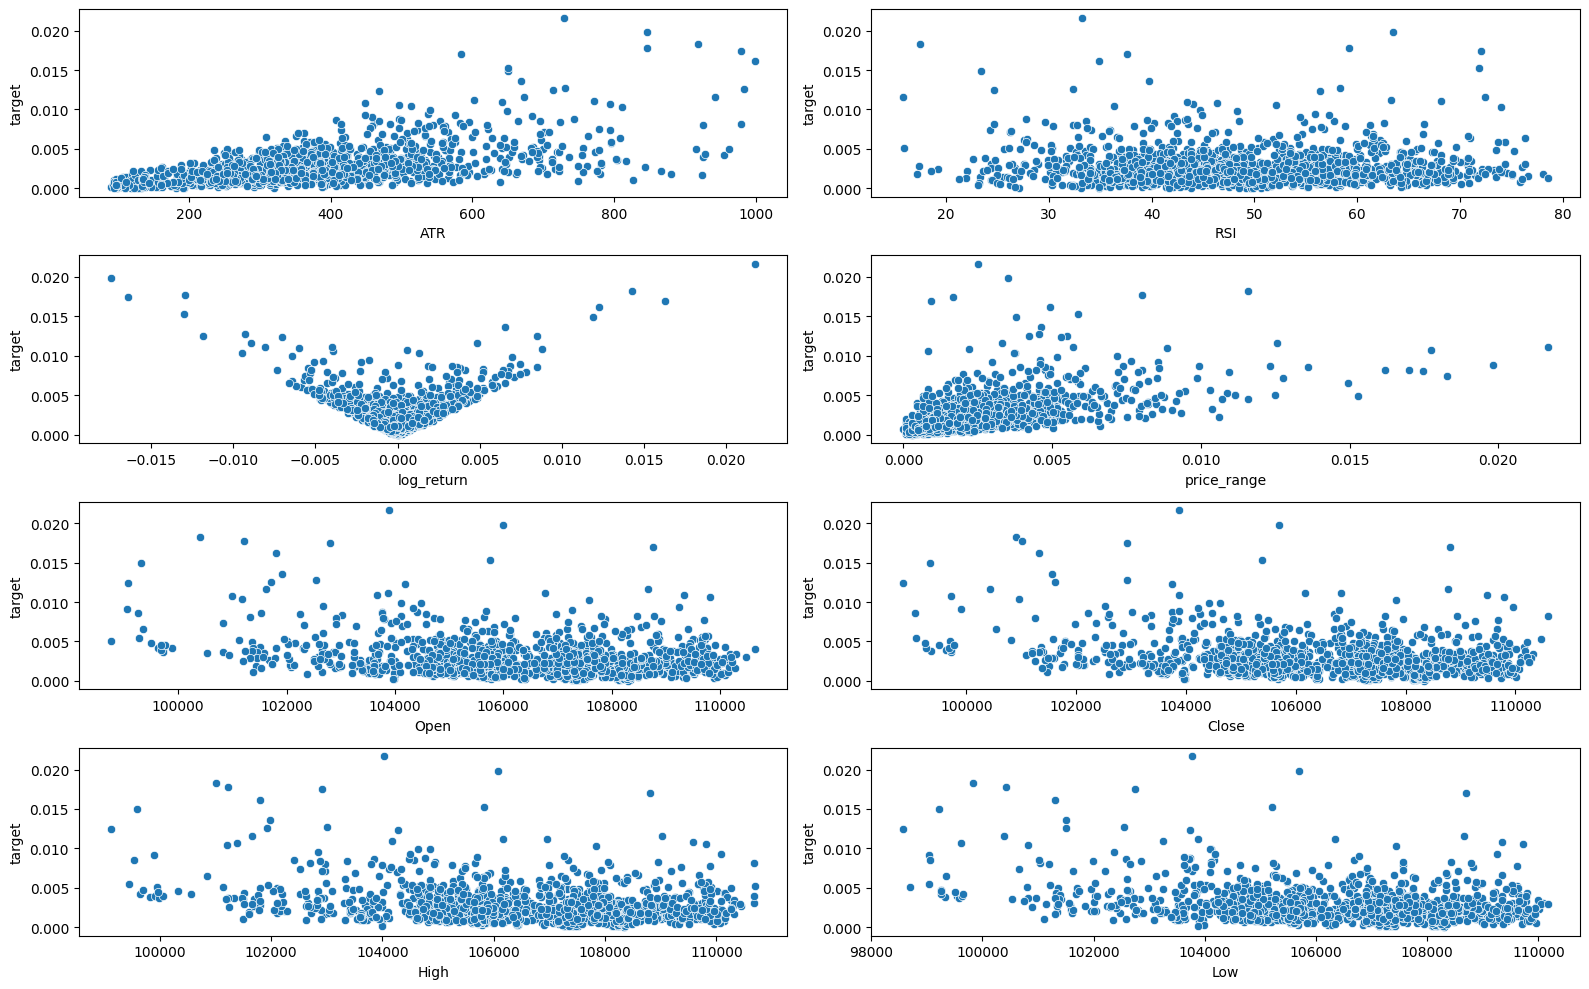

In [74]:
plt.rcParams["figure.figsize"] = [16,10]
#sns.set_palette(colors[3:8:3])
plt.subplot(4,2,1)
sns.scatterplot(data = df, x = df['ATR'], y = df['target'])
plt.xlabel("ATR")
plt.ylabel("target")
plt.subplot(4,2,2)
sns.scatterplot(data = df, x = df['RSI'], y = df['target'])
plt.xlabel("RSI")
plt.ylabel("target")
plt.subplot(4,2,3)
sns.scatterplot(data = df, x = df['log_return'], y = df['target'])
plt.xlabel("log_return")
plt.ylabel("target")
plt.subplot(4,2,4)
sns.scatterplot(data = df, x = df['price_range'], y = df['target'])
plt.xlabel("price_range")
plt.ylabel("target")
plt.subplot(4,2,5)
sns.scatterplot(data = df, x = df['Open'], y = df['target'])
plt.xlabel("Open")
plt.ylabel("target")
plt.subplot(4,2,6)
sns.scatterplot(data = df, x = df['Close'], y = df['target'])
plt.xlabel("Close")
plt.ylabel("target")
plt.subplot(4,2,7)
sns.scatterplot(data = df, x = df['High'], y = df['target'])
plt.xlabel("High")
plt.ylabel("target")
plt.subplot(4,2,8)
sns.scatterplot(data = df, x = df['Low'], y = df['target'])
plt.xlabel("Low")
plt.ylabel("target")

plt.tight_layout()
plt.show()

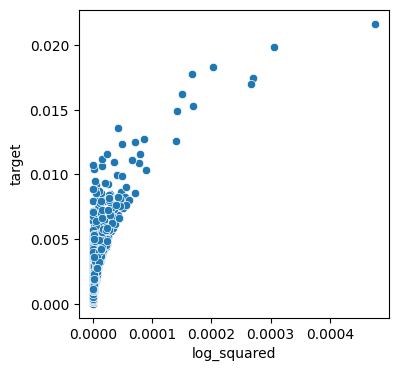

In [75]:
df['log_squared']=df['log_return']**2
fig = plt.figure(figsize = (4,4))
sns.scatterplot(data = df, x = df['log_squared'], y = df['target'])
plt.xlabel("log_squared")
plt.ylabel("target")
plt.show()

**Calculating absolute log_return as target vs log_return showed a 'V' shaped curve**

In [76]:
df['abs_log_return'] = abs(df['log_return'])

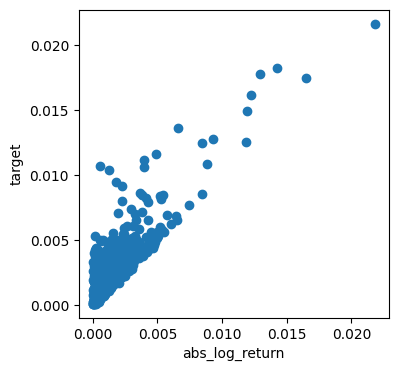

In [27]:
x = df['abs_log_return']
y = df['target']
fig = plt.figure(figsize = (4,4))
plt.scatter(x,y)
plt.xlabel("abs_log_return")
plt.ylabel("target")
plt.show()

In [108]:
df[['log_squared','abs_log_return', 'target']].corr()

,log_squared,abs_log_return,target
log_squared,1.000000000,0.850154338,0.718039338
abs_log_return,0.850154338,1.000000000,0.843756405
target,0.718039338,0.843756405,1.000000000


* Absolute value of Log has better correlation with Volatility i.e. price range of after 30 minutes than Log Squared value. So I'll go for abs_log'

**Calculating absolute RSI and absolute Log volume**

In [109]:
df['abs_rsi']= abs(df['RSI']-50)
df.head(2)

,MTS,Open,Close,High,Low,Volume,DateTime,log_return,price_range,ATR,RSI,target,log_squared,abs_log_return,abs_rsi,log_vol
13,1751823000000,108990,109050,109130,108990,5.052000100,2025-07-06 17:30:00,-0.003398708,0.001283815,377.857142857,49.491766977,0.003496503,0.000011551,0.003398708,0.508233023,1.800388812
14,1751821200000,108990,109000,109000,108880,0.975287530,2025-07-06 17:00:00,0.000458610,0.001100917,363.010204082,47.896043916,0.001283815,0.000000210,0.000458610,2.103956084,0.680713973


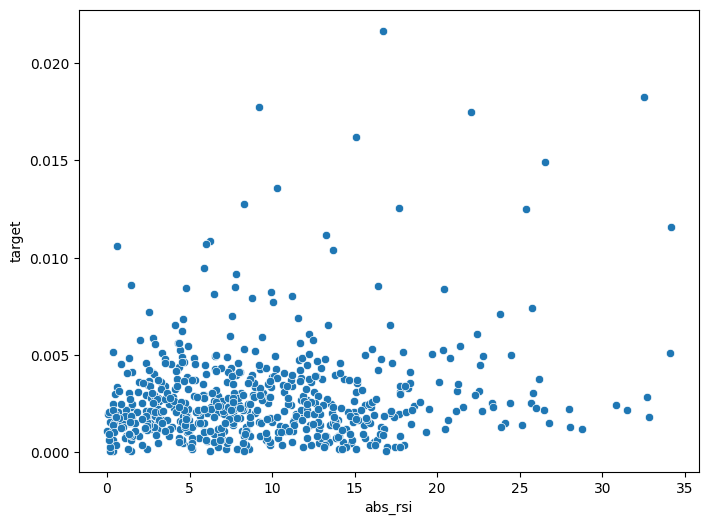

In [30]:
fig = plt.figure(figsize = (8,6))
sns.scatterplot(data = df, x = df['abs_rsi'], y = df['target'])
plt.xlabel("abs_rsi")
plt.ylabel("target")
plt.show()

**Target vs Volume plot**

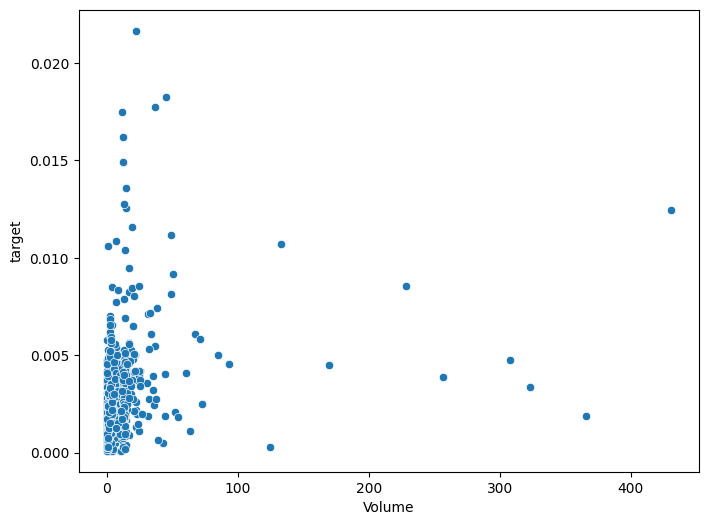

In [31]:
fig = plt.figure(figsize = (8,6))
sns.scatterplot(data = df, x = df['Volume'], y = df['target'])
plt.xlabel("Volume")
plt.ylabel("target")
plt.show()

In [79]:
df[df['Volume']==0]

,MTS,Open,Close,High,Low,Volume,DateTime,log_return,price_range,ATR,RSI,target,log_squared,abs_log_return,abs_rsi


**Calculating log of volume as Volume itself shows a skewed nature towards right**

In [80]:
df['log_vol'] = np.log(df['Volume']+1)  # Adding +1 as there are lot of case where the volume is very close to 0

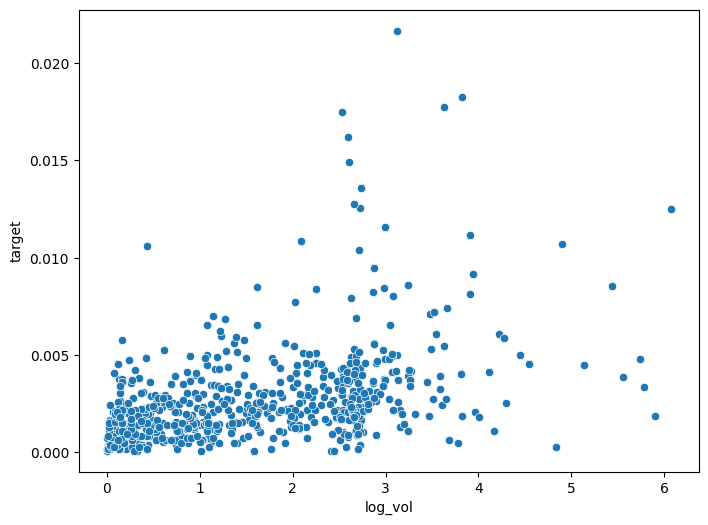

In [34]:
fig = plt.figure(figsize = (8,6))
sns.scatterplot(data = df, x = df['log_vol'], y = df['target'])
plt.xlabel("log_vol")
plt.ylabel("target")
plt.show()

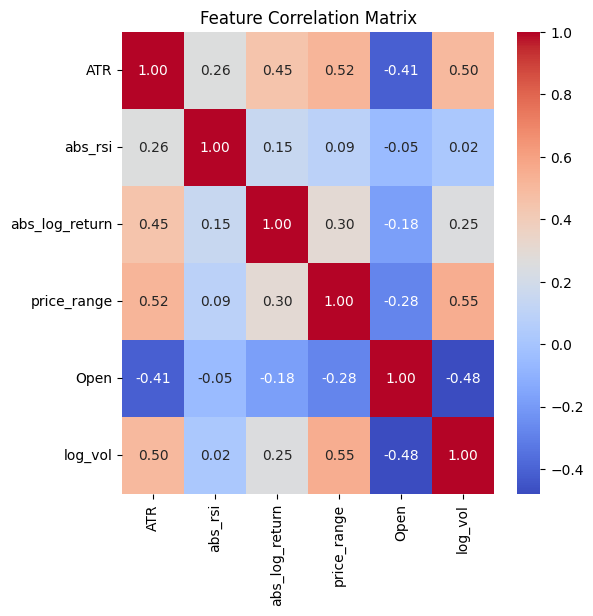

In [ ]:
features = df[['ATR', 'abs_rsi', 'abs_log_return', 'price_range', 'Open', 'log_vol']]
corr_matrix = features.corr()

plt.figure(figsize=(6, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

*The variable 'Open' is likely to be a confound variable*

In [35]:
df.head(2)

,MTS,Open,Close,High,Low,Volume,DateTime,log_return,price_range,ATR,RSI,target,log_squared,abs_log_return,abs_rsi,log_vol
13,1751563800000,109640,109720,109760,109640,0.612841,2025-07-03 17:30:00,0.000364,0.001094,186.428571,43.24906,0.002915,1.328587e-07,0.000364,6.75094,0.477997
14,1751562000000,109480,109650,109810,109470,0.148272,2025-07-03 17:00:00,0.000638,0.003101,197.397959,39.21517,0.001094,4.072880e-07,0.000638,10.78483,0.138258


In [105]:
X_vif = df.drop(columns = ['target', 'DateTime', 'MTS'])
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

print(vif_data)

           feature                 VIF
0             Open    932820.359939214
1            Close   1093920.881778132
2             High 147190345.290763080
3              Low 143507133.426784694
4           Volume         1.906649913
5       log_return         1.154807762
6      price_range      1797.288717714
7              ATR        12.338164115
8              RSI        24.580733194
9      log_squared         4.057423901
10  abs_log_return         7.461004112
11         abs_rsi         3.240361477
12         log_vol         7.046247440


In [106]:
X_vif = df.drop(columns = ['target', 'DateTime', 'MTS', 'Close', 'Low', 'High','Volume'])
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

print(vif_data)

          feature          VIF
0            Open 29.477468824
1      log_return  1.144267480
2     price_range  3.975794154
3             ATR 11.576800432
4             RSI 23.447257694
5     log_squared  4.024921166
6  abs_log_return  7.377426969
7         abs_rsi  3.228395996
8         log_vol  4.912120691


In [107]:
X_vif = df.drop(columns = ['target', 'DateTime', 'MTS', 'Close', 'Low', 'High','Volume','Open','log_return','RSI'])
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

print(vif_data)

          feature         VIF
0     price_range 3.938285407
1             ATR 8.269594706
2     log_squared 3.744743612
3  abs_log_return 7.153556687
4         abs_rsi 2.831937333
5         log_vol 4.790290471


In [39]:
df.head(2)

,MTS,Open,Close,High,Low,Volume,DateTime,log_return,price_range,ATR,RSI,target,log_squared,abs_log_return,abs_rsi,log_vol
13,1751563800000,109640,109720,109760,109640,0.612841,2025-07-03 17:30:00,0.000364,0.001094,186.428571,43.24906,0.002915,1.328587e-07,0.000364,6.75094,0.477997
14,1751562000000,109480,109650,109810,109470,0.148272,2025-07-03 17:00:00,0.000638,0.003101,197.397959,39.21517,0.001094,4.072880e-07,0.000638,10.78483,0.138258


In [84]:
X = df[['price_range', 'ATR', 'abs_log_return', 'abs_rsi', 'log_vol']]
y = df['target']

**Split the data chronologically**

In [85]:
split_point = int(0.8 * len(df))
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

**Scale the features**

In [95]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [96]:
# Train Lasso
alphas = np.logspace(-4, -1, 50)  # From 0.0001 to 0.1
lasso = LassoCV(alphas=alphas, cv=5, random_state=42, max_iter=10000).fit(X_train_scaled, y_train)
lasso_pred = lasso.predict(X_test_scaled)
print(f"Lasso Test MSE: {mean_squared_error(y_test, lasso_pred)}")
print(f"Best Lasso Alpha: {lasso.alpha_}")
print(f"The R2_score : {r2_score(y_test, lasso_pred)}")

Lasso Test MSE: 1.1459186872519466e-06
Best Lasso Alpha: 0.0001
The R2_score : 0.7972547381418944


*As best lasso alpha is 0.0001, it's the lowest point of the given range. So we will try this time expanding the search space*

In [98]:
# Train Lasso
alphas = np.logspace(-6, -1, 50)  # From 0.0001 to 0.1
lasso = LassoCV(alphas=alphas, cv=5, random_state=42, max_iter=10000).fit(X_train_scaled, y_train)
lasso_pred = lasso.predict(X_test_scaled)
print(f"Lasso Test MSE: {mean_squared_error(y_test, lasso_pred)}")
print(f"Lasso Test MAE: {mean_absolute_error(y_test, lasso_pred)}")
print(f"Lasso Test RMSE: {root_mean_squared_error(y_test, lasso_pred)}")
print(f"The R2_score : {r2_score(y_test, lasso_pred)}")
print(f"Best Lasso Alpha: {lasso.alpha_}")

Lasso Test MSE: 1.0738819272674644e-06
Lasso Test MAE: 0.0006953818113584941
Lasso Test RMSE: 0.0010362827448469189
The R2_score : 0.8100000680932613
Best Lasso Alpha: 8.286427728546843e-06


In [99]:
# Create a pandas Series to see the feature names next to their coefficients
coeffs = pd.Series(lasso.coef_, index=X.columns)
pd.set_option('display.float_format', '{:.9f}'.format)

print("Lasso Coefficients:")
print(coeffs.sort_values(ascending=False))

Lasso Coefficients:
abs_log_return    0.001477999
price_range       0.000327344
ATR               0.000318323
log_vol           0.000084306
abs_rsi          -0.000035249
dtype: float64


In [100]:
# Train Ridge
ridge = RidgeCV(alphas=np.logspace(-4, 2, 100), cv=5).fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_test_scaled)
print(f"Ridge Test MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"Ridge Test MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"Ridge Test RMSE: {root_mean_squared_error(y_test, ridge_pred)}")
print(f"The R2_score : {r2_score(y_test, ridge_pred)}")
print(f"Best Ridge Alpha: {ridge.alpha_}")

Ridge Test MSE: 1.0703155139671572e-06
Ridge Test MAE: 0.000694852038072402
Ridge Test RMSE: 0.0010345605414702212
The R2_score : 0.8106310669647423
Best Ridge Alpha: 0.0001


In [93]:
# Create a pandas Series to see the feature names next to their coefficients
coeffs = pd.Series(ridge.coef_, index=X.columns)
pd.set_option('display.float_format', '{:.9f}'.format)

print("Lasso Coefficients:")
print(coeffs.sort_values(ascending=False))

Lasso Coefficients:
abs_log_return   0.001659572
price_range      0.000600994
ATR              0.000314259
log_vol          0.000066015
abs_rsi          0.000011105
dtype: float64
